In [2]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=f24862d9484843bc34b316c09ab04c797ccefb357812dc4adda27bb02611f94a
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from apyori import apriori


In [4]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [8]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [9]:
rating.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

In [10]:
# deleting the rows with rating -1
rating = rating[rating["rating"] != -1]

In [11]:
print(f"anime.csv - rows: {anime.shape[0]}, columns: {anime.shape[1]}")
print(f"rating.csv - rows: {rating.shape[0]}, columns: {rating.shape[1]}")

anime.csv - rows: 12294, columns: 7
rating.csv - rows: 6337241, columns: 3


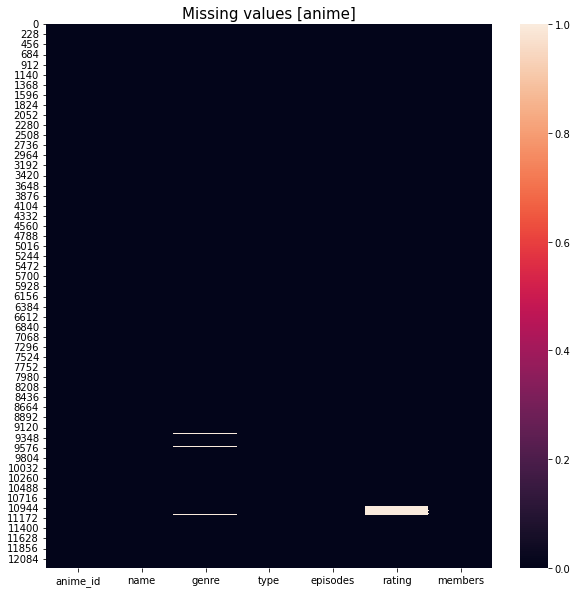

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(anime.isnull())
plt.title("Missing values [anime]", fontsize = 15)
plt.show()

There are some missing values in the dataset.

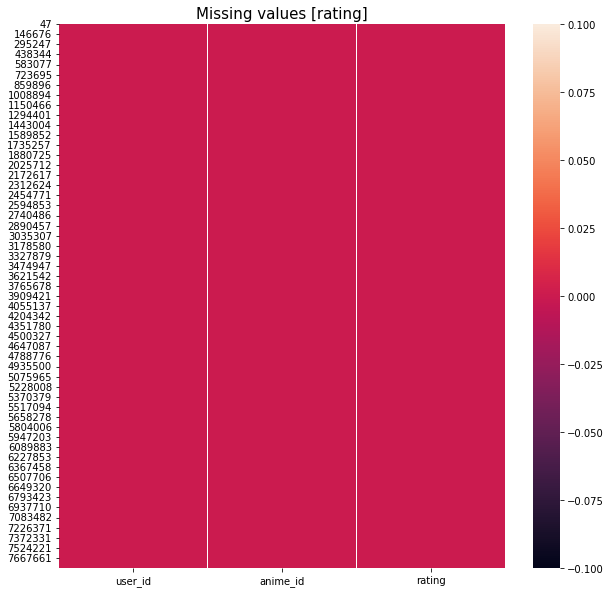

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(rating.isnull())
plt.title("Missing values [rating]", fontsize = 15)
plt.show()

#### Preparing The Data

In [14]:
# Merge anime and rating using "anime_id" as reference
df = pd.merge(anime,rating,on='anime_id')
df.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


In [15]:
count_rating = df.groupby("name")["rating_x"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25290
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
Gun-dou Musashi Recap                  1
Ushi Atama                             1
Futago no Ookami Daibouken             1
Cencoroll 2                            0
Steins;Gate 0                          0
Name: rating_x, Length: 9926, dtype: int64

In [16]:
#There are a lot of animes with only 1 rating. So, we will ignore those and keep animes with atleast 'r' number of ratings.
r = 5000
more_than_r_ratings = count_rating[count_rating.apply(lambda x: x >= r)].index
df_r = df[df['name'].apply(lambda x: x in more_than_r_ratings)]

In [17]:
before = len(df.name.unique())
after = len(df_r.name.unique())
rows_before = df.shape[0]
rows_after = df_r.shape[0]

In [18]:
print(f'''{before} Animes before filtering ---- {after} Animes after the filtering
{before} animes => {after} animes
{rows_before} rows before filtering => {rows_after} rows after filtering''')

9926 Animes before filtering ---- 279 Animes after the filtering
9926 animes => 279 animes
6337239 rows before filtering => 2517097 rows after filtering


### Data Analysis

In [19]:
anime['name'].unique()[3:10]

array(['Steins;Gate', 'Gintama&#039;',
       'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
       'Gintama&#039;: Enchousen'], dtype=object)

In [20]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)
    
    return text

anime['name'] = anime['name'].apply(text_cleaning)

In [21]:
anime['name'].unique()[3:10]

array(['SteinsGate', 'Gintama039',
       'Haikyuu Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter 2011', 'Ginga Eiyuu Densetsu',
       'Gintama Movie Kanketsuhen  Yorozuya yo Eien Nare',
       'Gintama039 Enchousen'], dtype=object)

In [22]:
anime.episodes.replace({'Unknown':np.nan},inplace=True)

In [23]:
df.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)

In [24]:
df

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10
...,...,...,...,...,...,...,...,...,...
6337234,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,58483,1
6337235,5543,Under World,Hentai,OVA,1,4.28,183,49503,4
6337236,5543,Under World,Hentai,OVA,1,4.28,183,58483,1
6337237,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,49503,6


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337239 entries, 0 to 6337238
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   avg_rating   float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 483.5+ MB


In [26]:
df.shape

(6337239, 9)

In [27]:
df.dtypes

anime_id         int64
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id          int64
user_rating      int64
dtype: object

In [28]:
df['anime_id']=df.anime_id.astype('object')
df['user_id']=df.user_id.astype('object')

In [29]:
df.dtypes

anime_id        object
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id         object
user_rating      int64
dtype: object

In [30]:
missing_value = pd.DataFrame({
    'Missing Value': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df))*100
})

In [31]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
genre,88,0.001389
avg_rating,5,0.000079
type,4,0.000063
anime_id,0,0.000000
name,0,0.000000
episodes,0,0.000000
members,0,0.000000
user_id,0,0.000000
user_rating,0,0.000000


In [32]:
df.dropna(inplace=True)
anime.dropna(inplace=True)

In [33]:
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [34]:
duplicate = df.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 7 duplicated rows in the data


In [35]:
duplicate = anime.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


In [36]:
df.drop_duplicates(subset=['anime_id','user_id'],inplace=True)

In [37]:
duplicate = df.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


In [38]:
df.shape

(6337139, 9)

In [39]:
df.tail()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
6337234,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,58483,1
6337235,5543,Under World,Hentai,OVA,1,4.28,183,49503,4
6337236,5543,Under World,Hentai,OVA,1,4.28,183,58483,1
6337237,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,49503,6
6337238,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4


In [40]:
df.reset_index(drop=True,inplace=True)
df.tail()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
6337134,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,58483,1
6337135,5543,Under World,Hentai,OVA,1,4.28,183,49503,4
6337136,5543,Under World,Hentai,OVA,1,4.28,183,58483,1
6337137,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,49503,6
6337138,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4


In [41]:
df.shape

(6337139, 9)

In [42]:
df.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


There are now no Missing or Duplicate Values in the Dataset

In [43]:
df.describe()

,avg_rating,members,user_rating
count,6.337139e+06,6.337139e+06,6.337139e+06
mean,7.675013e+00,1.845763e+05,7.808543e+00
std,6.699057e-01,1.909528e+05,1.572439e+00
min,2.000000e+00,3.300000e+01,1.000000e+00
25%,7.290000e+00,4.680300e+04,7.000000e+00
50%,7.700000e+00,1.170910e+05,8.000000e+00
75%,8.150000e+00,2.563250e+05,9.000000e+00
max,9.370000e+00,1.013917e+06,1.000000e+01


In [44]:
df.describe(include='object')

,anime_id,name,genre,type,episodes,user_id
count,6337139,6337139,6337139,6337139,6337139,6337139
unique,9892,9892,3048,6,178,69600
top,1535,Death Note,"Comedy, School, Slice of Life",TV,12,42635
freq,34226,34226,49850,4364287,1420729,3747


In [45]:
corr_matrix=df.corr()
corr_matrix

,avg_rating,members,user_rating
avg_rating,1.000000,0.541074,0.410683
members,0.541074,1.000000,0.232404
user_rating,0.410683,0.232404,1.000000


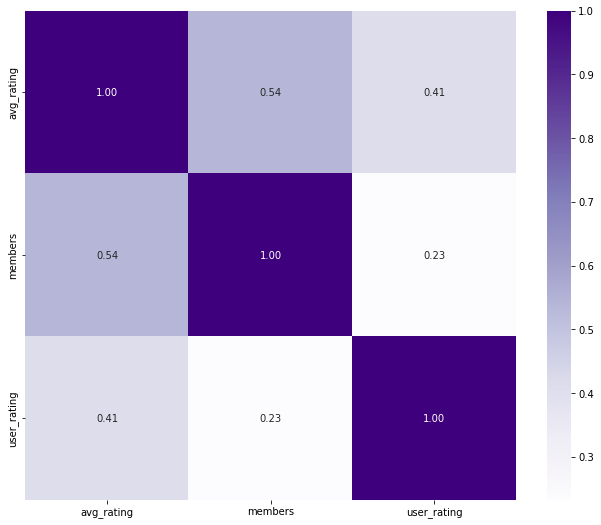

In [46]:
plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix, cmap='Purples', annot=True, fmt=".2f")
sns.set(font_scale=1.5)

There is no Strong Relation between any attributes

In [47]:
nonull_anime=df.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

(-0.5, 799.5, 399.5, -0.5)

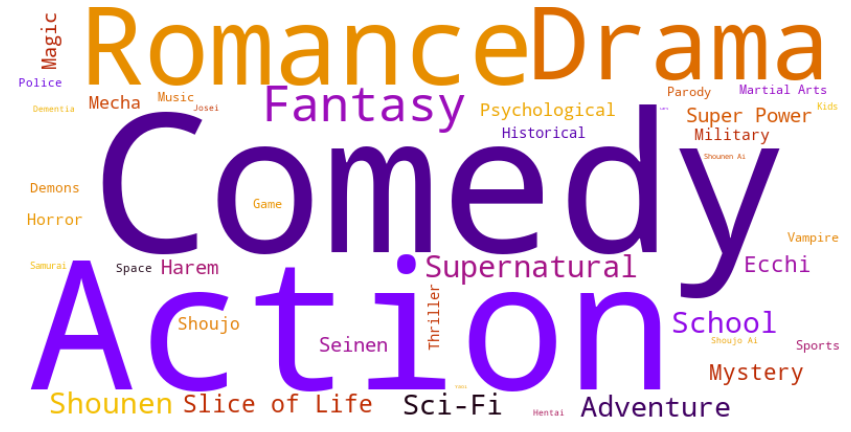

In [48]:
plt.figure(figsize=(15,10))        
from wordcloud import WordCloud
genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

In [49]:
df_count = df.groupby(by = ['name'])['user_rating'].count().reset_index()[['name', 'user_rating']]
df_count.rename(columns = {'user_rating': 'totalRatingCount'},inplace=True)
df_count.head()

,name,totalRatingCount
0,&quot;0&quot;,17
1,&quot;Aesop&quot; no Ohanashi yori: Ushi to Ka...,1
2,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hat...,635
3,&quot;Bungaku Shoujo&quot; Memoire,662
4,&quot;Bungaku Shoujo&quot; Movie,1295


Text(0, 0.5, 'User Rating count')

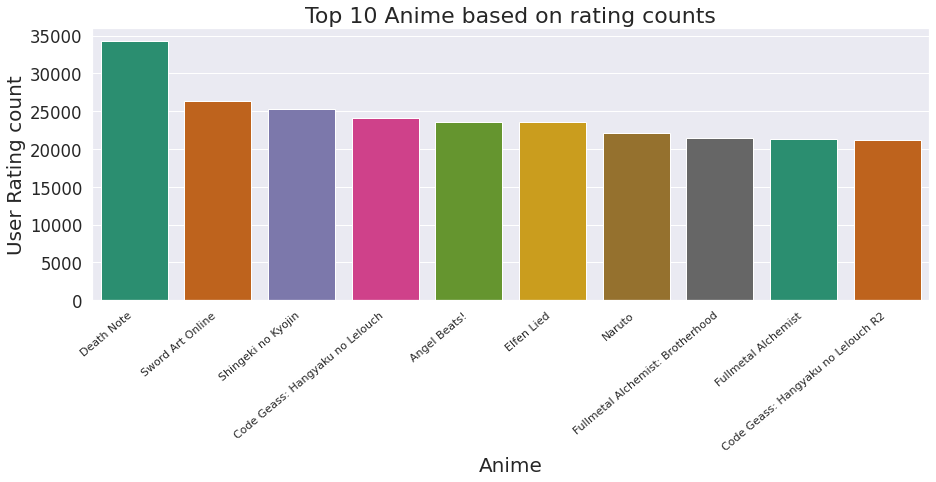

In [50]:
df_top10=df_count[['name', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="totalRatingCount", data=df_top10, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

In [51]:
df_data=df.merge(df_count, left_on = 'name', right_on = 'name', how = 'left')
print("Top 10 Anime Based on Community Size(Members)")
df_data.head()


Top 10 Anime Based on Community Size(Members)


,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating,totalRatingCount
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,1961
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,1961
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,1961
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,1961
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10,1961


In [52]:
df_data.duplicated(subset=['name']).sum()

6327247

In [53]:
df1=df_data.drop_duplicates(subset=['name'])
df1.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating,totalRatingCount
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,1961
1961,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3,10,21494
23455,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,43,10,1188
24643,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,5,9,17151
41794,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5,9,3115


Text(0, 0.5, 'Community Size')

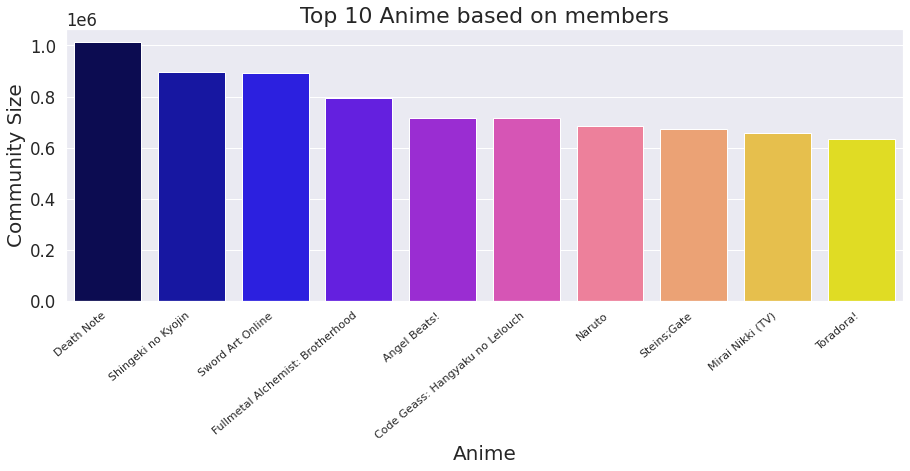

In [54]:
df1_top10=df1[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="members", data=df1_top10, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

Death Note has the larget community followed by Shingeki No Kyojin and Sword Art Online

Text(0.5, 1.0, 'Rating of users')

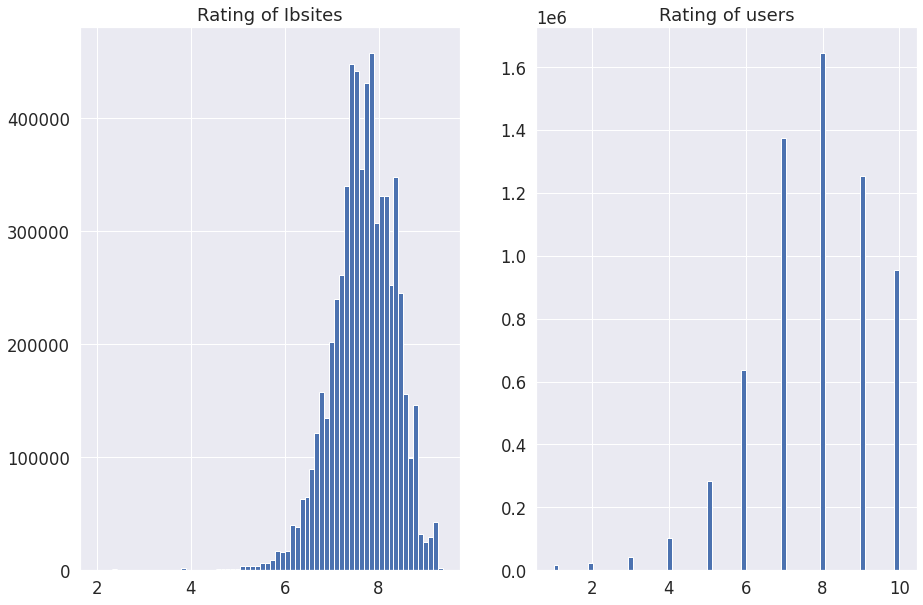

In [55]:
plt.figure(figsize = (15, 10))
plt.subplot(1,2,1)
df['avg_rating'].hist(bins=70)
plt.title("Rating of Ibsites")
plt.subplot(1,2,2)
df['user_rating'].hist(bins=70)
plt.title("Rating of users")

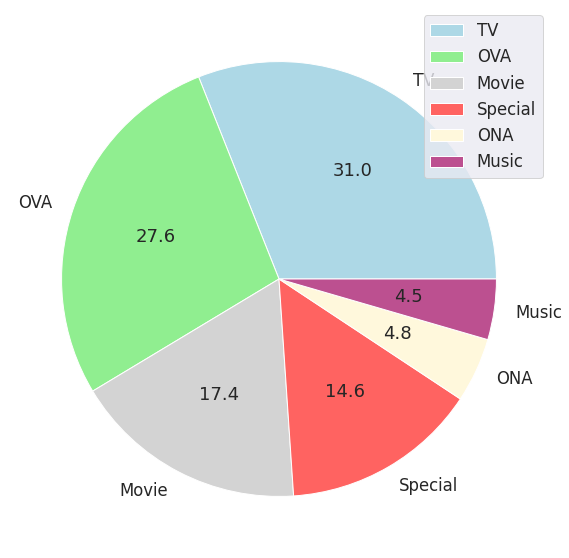

In [56]:
labels = df1['type'].value_counts().index
values = df1['type'].value_counts().values
plt.figure(figsize=(15,10))
plt.pie(x=values,labels=labels,autopct='%.1f',colors=['lightblue','lightgreen','lightgrey','#FF6361','Cornsilk','#BC5090'])
plt.legend()
plt.show()

In [57]:
d1=pd.DataFrame(list(dict(all_genres).keys()),columns=['Genre'])
d2=pd.DataFrame(list(dict(all_genres).values()),columns=['count'])

In [58]:
df_genres1=pd.concat(objs=(d1,d2),axis=1)
df_genres1.head()

,Genre,count
0,Drama,1727681
1,Romance,2031672
2,School,1540797
3,Supernatural,1612455
4,Action,2663837


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


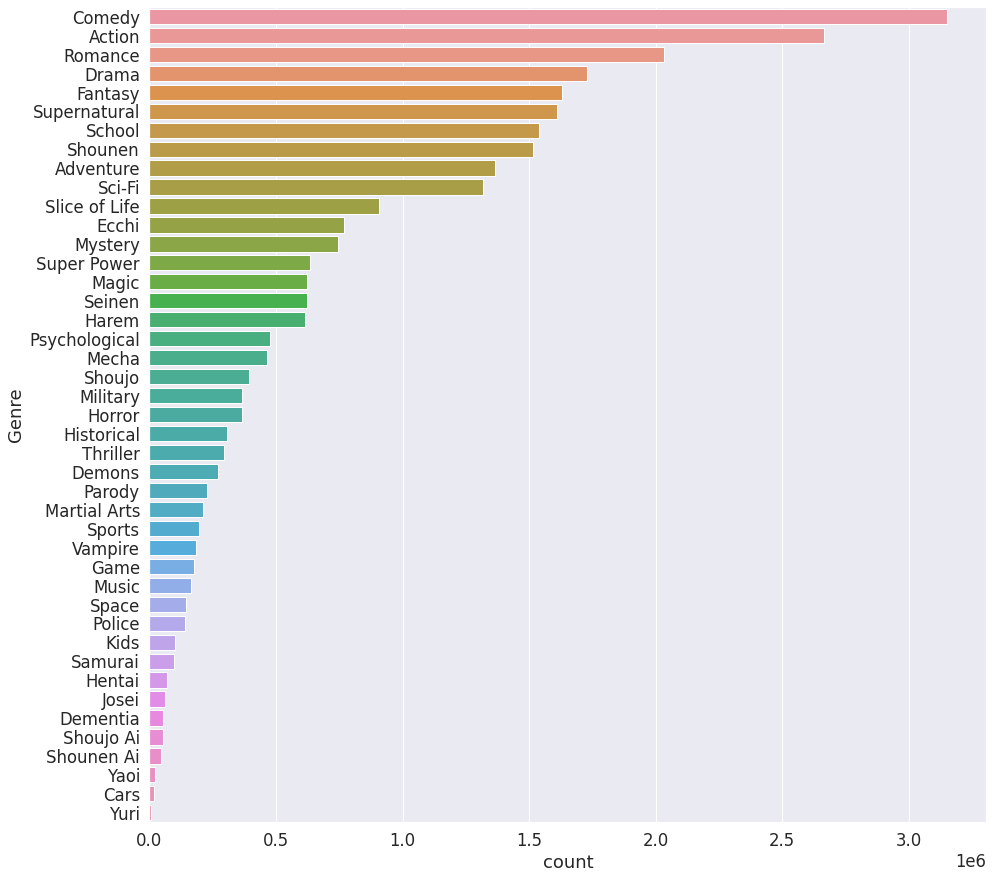

In [59]:
df_genres1=df_genres1.sort_values(by='count',ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(df_genres1['count'],df_genres1['Genre'])

#### Data Preprocessing

In [60]:
genres = anime['genre'].str.split(',', expand=True)
genres.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None


In [61]:
genres = genres.iloc[:,:4]
genres.columns = ['genre1', 'genre2', 'genre3','genre4']
genres.head()

,genre1,genre2,genre3,genre4
0,Drama,Romance,School,Supernatural
1,Action,Adventure,Drama,Fantasy
2,Action,Comedy,Historical,Parody
3,Sci-Fi,Thriller,None,None
4,Action,Comedy,Historical,Parody


In [62]:
updated_rating=anime.copy()
updated_rating = updated_rating.drop('genre', axis=1) 
updated_rating = pd.concat([updated_rating, genres], axis=1)
updated_rating.head()

,anime_id,name,type,episodes,rating,members,genre1,genre2,genre3,genre4
0,32281,Kimi no Na wa,Movie,1,9.37,200630,Drama,Romance,School,Supernatural
1,5114,Fullmetal Alchemist Brotherhood,TV,64,9.26,793665,Action,Adventure,Drama,Fantasy
2,28977,Gintama°,TV,51,9.25,114262,Action,Comedy,Historical,Parody
3,9253,SteinsGate,TV,24,9.17,673572,Sci-Fi,Thriller,None,None
4,9969,Gintama039,TV,51,9.16,151266,Action,Comedy,Historical,Parody


In [63]:
updated_rating['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [64]:
updated_rating.episodes=updated_rating.episodes.astype('int')
df_cat = updated_rating.select_dtypes(np.object)
df_num = updated_rating.select_dtypes(np.number)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [65]:
df_dum = pd.get_dummies(df_cat[['type','genre1','genre2','genre3','genre4']])
df_dum.head()

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre1_Action,genre1_Adventure,genre1_Cars,genre1_Comedy,...,genre4_ Shounen Ai,genre4_ Slice of Life,genre4_ Space,genre4_ Sports,genre4_ Super Power,genre4_ Supernatural,genre4_ Thriller,genre4_ Vampire,genre4_ Yaoi,genre4_ Yuri
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
df_num.head()

,anime_id,episodes,rating,members
0,32281,1,9.37,200630
1,5114,64,9.26,793665
2,28977,51,9.25,114262
3,9253,24,9.17,673572
4,9969,51,9.16,151266


In [67]:
df_num.set_index('anime_id',inplace=True)
df_num.head()

,episodes,rating,members
anime_id,,,
32281,1,9.37,200630
5114,64,9.26,793665
28977,51,9.25,114262
9253,24,9.17,673572
9969,51,9.16,151266


In [68]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
df_num
df_scale = pd.DataFrame(ss.fit_transform(df_num),columns=df_num.columns)
df_scale.head()

,episodes,rating,members
0,-0.243905,2.831301,3.289181
1,1.093813,2.723363,13.999758
2,0.817776,2.713551,1.729322
3,0.244468,2.635050,11.830805
4,0.817776,2.625238,2.397637


In [69]:
df_dum.reset_index(drop=True,inplace=True)
full_df = pd.concat([df_scale,df_dum],axis=1)
full_df.head()

,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre1_Action,...,genre4_ Shounen Ai,genre4_ Slice of Life,genre4_ Space,genre4_ Sports,genre4_ Super Power,genre4_ Supernatural,genre4_ Thriller,genre4_ Vampire,genre4_ Yaoi,genre4_ Yuri
0,-0.243905,2.831301,3.289181,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.093813,2.723363,13.999758,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0.817776,2.713551,1.729322,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0.244468,2.635050,11.830805,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.817776,2.625238,2.397637,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [70]:
full_df.shape

(11830, 171)